## open ltm dictionary, plot and analyze variables from each of the three datasets 

In [95]:
# data processing
import os
import pandas as pd, numpy as np, dask, json
import ogh
import geopandas as gpd
import ogh_xarray_landlab as oxl
import xarray as xr
import scipy.io

# data migration library
from utilities import hydroshare

# plotting and shape libraries
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [96]:
#hs=hydroshare.hydroshare()
#homedir = hs.getContentPath(os.environ["HS_RES_ID"])
homedir = '/home/jovyan/work/notebooks/GriddedMetDataDownload/projects/TemperatureSensorRegion'
os.chdir(homedir)
print('Data will be saved to:'+homedir)

Data will be saved to:/home/jovyan/work/notebooks/GriddedMetDataDownload/projects/TemperatureSensorRegion


In [97]:
# initialize ogh_meta
meta_file = dict(ogh.ogh_meta())
sorted(meta_file.keys())

['dailymet_bclivneh2013',
 'dailymet_livneh2013',
 'dailymet_livneh2015',
 'dailyvic_livneh2013',
 'dailyvic_livneh2015',
 'dailywrf_bcsalathe2014',
 'dailywrf_salathe2014',
 'hourlywrf_pnnl']

### Load dictionary of data from all three datasets (livneh 2013, salathe 2014, PNNL 2018)

In [98]:
import pickle 
infile = open('TempSensorArea_2001to2015.pkl','rb') #rb - read binary
ltm = pickle.load(infile)
infile.close()

In [99]:
#check variables saved in dictionary
ltm.keys()

dict_keys(['PRECIP_dailymet_livneh2013', 'TMAX_dailymet_livneh2013', 'TMIN_dailymet_livneh2013', 'WINDSPD_dailymet_livneh2013', 'meanalldailysum_PRECIP_dailymet_livneh2013', 'monthsum_PRECIP_dailymet_livneh2013', 'meanbymonthsum_PRECIP_dailymet_livneh2013', 'meanmonthsum_PRECIP_dailymet_livneh2013', 'meanallmonthsum_PRECIP_dailymet_livneh2013', 'yearsum_PRECIP_dailymet_livneh2013', 'meanbyyearsum_PRECIP_dailymet_livneh2013', 'meanyearsum_PRECIP_dailymet_livneh2013', 'meanallyearsum_PRECIP_dailymet_livneh2013', 'PRECIP_dailywrf_salathe2014', 'TMAX_dailywrf_salathe2014', 'TMIN_dailywrf_salathe2014', 'WINDSPD_dailywrf_salathe2014', 'meanalldailysum_PRECIP_dailywrf_salathe2014', 'monthsum_PRECIP_dailywrf_salathe2014', 'meanbymonthsum_PRECIP_dailywrf_salathe2014', 'meanmonthsum_PRECIP_dailywrf_salathe2014', 'meanallmonthsum_PRECIP_dailywrf_salathe2014', 'yearsum_PRECIP_dailywrf_salathe2014', 'meanbyyearsum_PRECIP_dailywrf_salathe2014', 'meanyearsum_PRECIP_dailywrf_salathe2014', 'meanallyear

### Load temperature observations from field

In [100]:
filename = 'NCascades_AT.mat'

mat = scipy.io.loadmat(filename)

#range of dates to create new files for
start_date = '2007-09-01 00:30' 
end_date = '2008-09-30 23:00'

Hdates = [x.strftime('%Y-%m-%d %H:%M') for x in pd.date_range(start=start_date, end=end_date, freq='1.5H')]
Hddates = pd.to_datetime(Hdates)

start_dated = '2007-09-01' 
end_dated = '2008-09-30'
Ddates = [x.strftime('%Y-%m-%d') for x in pd.date_range(start=start_dated, end=end_dated, freq='D')]
Dddates = pd.to_datetime(Ddates)

#create hourly time series
Hdata = mat['AT']
dfh = pd.DataFrame(Hdata, columns = mat['sensor'].tolist(), index = Hddates )

#create daily time series Tmax
Ddata = mat['AT_maxT']
dfd_mx = pd.DataFrame(Ddata, columns = mat['sensor'].tolist(),index = Dddates )

#create daily time series Tmin
Ddata = mat['AT_minT']
dfd_min = pd.DataFrame(Ddata, columns = mat['sensor'].tolist(),index = Dddates )


#create daily time series Tmin
Ddata = mat['AT_meanT']
dfd_min = pd.DataFrame(Ddata, columns = mat['sensor'].tolist(),index = Dddates )


In [101]:
dfh.columns[12]

(13,)

In [137]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'TIME', 'sensor', 'elev', 'lat', 'lon', 'AT', 'TIME_day', 'AT_minT', 'AT_maxT', 'AT_meanT', 'AT_range'])

In [202]:
mat['sensor'][0,12] #33,43

13

In [204]:
mat['elev'][0,14]

1843

### Define wateryear summary functions (ogh.aggregate_space_time_sum and average currently use annual year)

In [102]:
def WaterYear_Accum(df):
    
    """
    #df = S_PNNL_1981to1987['PREC_ACC_NC_hourlywrf_pnnl'] or any other dataframe in dictionary created by grid_clim_dict
    
    """
    #step 1, add water year (WY) column to data
    aa = df.index.to_series() #convert index to series so that lambda function can be applied 
    df['WY'] = aa.apply(lambda x: x.year if x.month < 10 else x.year+1)
    
    #step 2, remove datetime index to column, label column
    df_re = df.rename_axis('Date').reset_index()
    
    #step 3, move WY as index
    df_re.set_index('WY', inplace=True)
    
    #step 4, sum values in each column (grid point) by WY
    WYs_Sta = df_re.groupby(df_re.index).sum()
    
    #step 5, take mean of each grid cell as basin value
    WYs_basin = WYs_Sta.mean(axis=1)
    
    return(WYs_basin)


def WaterYear_Mean(df):
    
    """
    #df = S_PNNL_1981to1987['PREC_ACC_NC_hourlywrf_pnnl'] or any other dataframe in dictionary created by grid_clim_dict
    
    """
    #step 1, add water year (WY) column to data
    aa = df.index.to_series() #convert index to series so that lambda function can be applied 
    df['WY'] = aa.apply(lambda x: x.year if x.month < 10 else x.year+1)
    
    #step 2, remove datetime index to column, label column
    df_re = df.rename_axis('Date').reset_index()
    
    #step 3, move WY as index
    df_re.set_index('WY', inplace=True)
    
    #step 4, average values in each column (grid point) by WY
    WYm_Sta = df_re.groupby(df_re.index).mean()
    
    #step 5, take mean of each grid cell as basin value
    WYm_basin = WYm_Sta.mean(axis=1)
    
    return(WYm_basin)

### Analyze and plot variables

In [103]:
#create precip, temperature and solar radiation variables
PNNL_hp = ltm['PREC_ACC_NC_hourlywrf_pnnl']
#water year accumulated precip
WYp = WaterYear_Accum(PNNL_hp)
#water year mean temp
PNNL_hT = ltm['T2_hourlywrf_pnnl']
WYt = WaterYear_Mean(PNNL_hT)
#water year mean solar radiation W/m2
PNNL_hRs = ltm['SWDOWN_hourlywrf_pnnl']
WYs = WaterYear_Mean(PNNL_hRs)

#### Note: pnnl data is missing multi column index, add index back to pnnl variables

In [104]:
#Tmx_p_d = ltm['T2_hourlywrf_pnnl'].resample('D').max()
ltm['T2_hourlywrf_pnnl'].head()
#PNNL_hp.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,WY
2001-01-01 00:00:00,258.968842,257.480957,257.024109,257.332916,257.186951,256.994232,257.122345,256.548798,256.765167,259.218933,...,262.778839,262.704529,262.498352,260.840118,259.134674,262.999786,262.952209,262.628998,260.948090,2001
2001-01-01 01:00:00,257.610596,256.783783,256.267578,256.333069,255.972015,256.531555,256.684021,255.693100,256.127441,258.555573,...,261.228821,261.932343,261.582275,259.781372,258.151733,260.942932,261.281281,261.533508,259.824066,2001
2001-01-01 02:00:00,257.697937,256.820923,256.686951,256.480499,256.308044,256.845825,257.072906,256.352600,256.636810,258.639984,...,261.004333,261.815338,261.516541,259.681488,258.091431,260.703766,260.973816,261.435913,259.849487,2001
2001-01-01 03:00:00,258.277618,257.619690,257.541046,256.899384,257.212433,257.345795,257.977600,257.429840,257.699493,258.895660,...,261.582916,261.665497,261.267975,260.024323,258.441132,261.837097,261.093903,261.329834,260.080566,2001
2001-01-01 04:00:00,259.038757,258.291260,258.213654,257.435303,257.771271,257.940918,258.652954,258.070953,258.366028,259.480438,...,261.740967,260.350769,261.039764,260.401398,258.985596,261.730499,260.903259,261.289886,260.392975,2001


In [105]:
# check pnnl index
#reload column index
#RELOAD 1988 to 1994 because columns of orginal dataset also reset to index

# infile = open('TempSensorArea_2001to2015_SepartePereods.pkl','rb') #rb - read binary
# Ldict = pickle.load(infile)
# infile.close()
# os.chdir(homedir)


infile = open('TempSensorArea_2006to2010_SepartePereods.pkl','rb') #rb - read binary
Ldict = pickle.load(infile)
infile.close()
os.chdir(homedir)

PNNL_COL = Ldict[0]['PREC_ACC_NC_hourlywrf_pnnl'].columns
#Ldict[0]['PREC_ACC_NC_hourlywrf_pnnl'].head(50).to_csv('PNNL_MultiIndex')

In [108]:
Ldict[0]['T2_hourlywrf_pnnl'].iloc[:,26].head(100)-273.15

2006-01-01 00:00:00    1.020593
2006-01-01 01:00:00    0.689600
2006-01-01 02:00:00    0.768365
2006-01-01 03:00:00    0.622156
2006-01-01 04:00:00    0.878900
2006-01-01 05:00:00    0.765070
2006-01-01 06:00:00    0.974512
2006-01-01 07:00:00    0.932611
2006-01-01 08:00:00    0.554163
2006-01-01 09:00:00    0.711267
2006-01-01 10:00:00    0.570825
2006-01-01 11:00:00    0.334650
2006-01-01 12:00:00    0.308893
2006-01-01 13:00:00    0.064508
2006-01-01 14:00:00   -0.057135
2006-01-01 15:00:00   -0.049384
2006-01-01 16:00:00   -2.380804
2006-01-01 17:00:00   -0.875464
2006-01-01 18:00:00   -0.492194
2006-01-01 19:00:00   -0.089850
2006-01-01 20:00:00   -0.024817
2006-01-01 21:00:00    0.371576
2006-01-01 22:00:00    0.134973
2006-01-01 23:00:00    0.089166
2006-01-02 00:00:00   -0.131720
2006-01-02 01:00:00   -0.247626
2006-01-02 02:00:00    0.062250
2006-01-02 03:00:00    0.263727
2006-01-02 04:00:00    0.141931
2006-01-02 05:00:00    0.133661
                         ...   
2006-01-

In [109]:
# check liv and sal index
ltm['PRECIP_dailywrf_salathe2014'].head(50).to_csv('VIC_MultiIndex')
#Ldict[0]['PREC_ACC_NC_hourlywrf_pnnl'].head(50).to_csv('PNNL_MultiIndex')

In [110]:
#### Load segements of data from indiviual netcdf files to check that concatenated datasets are correct
import pickle 
ddir = '/home/jovyan/work/notebooks/GriddedMetDataDownload/projects/TemperatureSensorRegion/PNNL/TempCheckJan2008/'
infile = open(ddir+'RawTempJan_SN58WE61.pkl','rb') #rb - read binary
T_W_SN58WE61 = pickle.load(infile)
infile.close()

infile = open(ddir+'RawTempJan_SN61WE57.pkl','rb') #rb - read binary
T_W_SN61WE57 = pickle.load(infile)
infile.close()

In [111]:
#### Load segements of data from indiviual netcdf files to check that concatenated datasets are correct
import pickle 
ddir = '/home/jovyan/work/notebooks/GriddedMetDataDownload/projects/TemperatureSensorRegion/PNNL/TempCheckJuneJuly2008/'
infile = open(ddir+'RawTempJune_SN58WE61.pkl','rb') #rb - read binary
T_S_SN58WE61 = pickle.load(infile)
infile.close()

infile = open(ddir+'RawTempJune_SN61WE57.pkl','rb') #rb - read binary
T_S_SN61WE57 = pickle.load(infile)
infile.close()

In [112]:
T_S_SN61WE57[0].resample('D').max()-273.15

SN,61
WE,57
TIME,
2008-06-01,13.558624


In [113]:
T_S_SN61WE57[2]-273.15

SN,61
WE,57
TIME,
2008-06-03 00:00:00,5.710205
2008-06-03 01:00:00,5.239441
2008-06-03 02:00:00,4.893402
2008-06-03 03:00:00,2.731049
2008-06-03 04:00:00,1.224152
2008-06-03 05:00:00,0.297607
2008-06-03 06:00:00,0.482513
2008-06-03 07:00:00,-0.217255


In [114]:
ltm['T2_hourlywrf_pnnl'].head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,WY
2001-01-01 00:00:00,258.968842,257.480957,257.024109,257.332916,257.186951,256.994232,257.122345,256.548798,256.765167,259.218933,...,262.778839,262.704529,262.498352,260.840118,259.134674,262.999786,262.952209,262.628998,260.948090,2001
2001-01-01 01:00:00,257.610596,256.783783,256.267578,256.333069,255.972015,256.531555,256.684021,255.693100,256.127441,258.555573,...,261.228821,261.932343,261.582275,259.781372,258.151733,260.942932,261.281281,261.533508,259.824066,2001
2001-01-01 02:00:00,257.697937,256.820923,256.686951,256.480499,256.308044,256.845825,257.072906,256.352600,256.636810,258.639984,...,261.004333,261.815338,261.516541,259.681488,258.091431,260.703766,260.973816,261.435913,259.849487,2001
2001-01-01 03:00:00,258.277618,257.619690,257.541046,256.899384,257.212433,257.345795,257.977600,257.429840,257.699493,258.895660,...,261.582916,261.665497,261.267975,260.024323,258.441132,261.837097,261.093903,261.329834,260.080566,2001
2001-01-01 04:00:00,259.038757,258.291260,258.213654,257.435303,257.771271,257.940918,258.652954,258.070953,258.366028,259.480438,...,261.740967,260.350769,261.039764,260.401398,258.985596,261.730499,260.903259,261.289886,260.392975,2001


### Plots

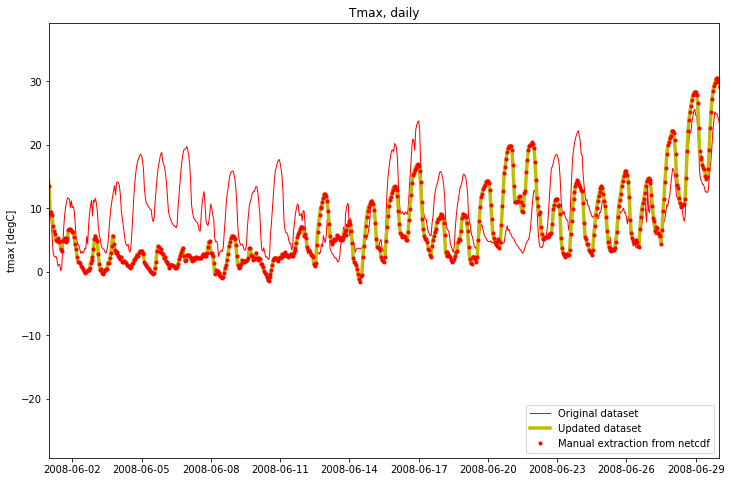

In [135]:
###CHECK THAT TEMP DATA is CORRECT
## daily Tmax

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
#ax.plot(dfd_mx.iloc[:,0],'c-',linewidth=2.0,alpha=.2,label = 'b1_Tmax')
#ax.plot(dfd_mx.iloc[:,6],'c-',linewidth=2.0,alpha=.5,label = 'b7_Tmax')
#ax.plot(dfd_mx.iloc[:,8],'c-',linewidth=2.0,alpha=.8,label = 'b9_Tmax')
#ax.plot(dfd_mx.iloc[:,10],'c-',linewidth=2.0,label = 'b11_Tmax')
#ax.plot(ltm['TMAX_dailywrf_salathe2014'].iloc[:,12],'b-',linewidth=2.0,label = 'S_Tmax')
#ax.plot(ltm['TMAX_dailymet_livneh2013'].iloc[:,12],'g-',linewidth=2.0,label = 'L_Tmax')
#ax.plot(ltm['T2_hourlywrf_pnnl'].iloc[:,26].resample('d').max()-273.15,'r-',linewidth=1.0,label = 'P_Tmax')
#for i in range(0,30):
#    ax.plot(T_S_SN61WE57[i].resample('d').max()-273.15,'r.',linewidth=2.5,label = 'P_Tmax')

ax.plot(ltm['T2_hourlywrf_pnnl'].iloc[:,26]-273.15,'r-',linewidth=1.0,label = 'Original dataset') ####PROBLEM with ltm
ax.plot(Ldict[0]['T2_hourlywrf_pnnl'].iloc[:,26]-273.15,'y-',linewidth=3.5,label = 'Updated dataset')
for i in range(0,30):
    if i == 0:
        ax.plot(T_S_SN61WE57[i]-273.15,'r.',linewidth=2.5, label='Manual extraction from netcdf')
    else:
        ax.plot(T_S_SN61WE57[i]-273.15,'r.',linewidth=2.5, label='_nolegend_')
# =============================================================================
# ax.plot(Tmx_S_d.index,Tmx_S_d,'g.',linewidth=2.0,label = 'Salathe')
# ax.plot(PNNL_hT_v_d_mx.index, PNNL_hT_v_d_mx,'r.',alpha = .2,linewidth=2.0,label = 'PNNL')
# 
# =============================================================================
plt.xlim(['2008-6-01','2008-06-30'])
# plt.ylim([0,1])
# plt.xticks(np.arange(0, 1.5, .25))
#plt.xlabel('date')
plt.ylabel('tmax [degC]')
plt.title('Tmax, daily')
#plt.grid()

legend = ax.legend(loc = 'lower right')
plt.savefig('LE_Tmax_Check_S.jpg', dpi = 300, bbox_inches='tight')

plt.show()

##indivual netcdf data looks correct, check that concatenated datasets are correct
##data set in chunk not correct

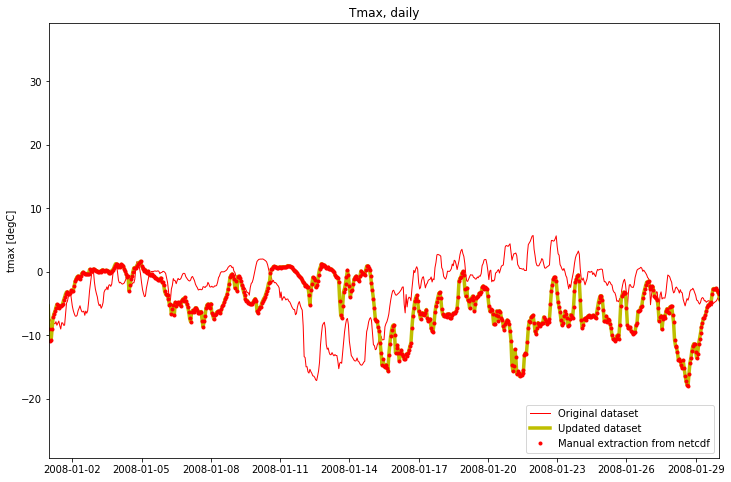

In [136]:
###CHECK THAT TEMP DATA is CORRECT
## daily Tmax

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
#ax.plot(dfd_mx.iloc[:,0],'c-',linewidth=2.0,alpha=.2,label = 'b1_Tmax')
#ax.plot(dfd_mx.iloc[:,6],'c-',linewidth=2.0,alpha=.5,label = 'b7_Tmax')
#ax.plot(dfd_mx.iloc[:,8],'c-',linewidth=2.0,alpha=.8,label = 'b9_Tmax')
#ax.plot(dfd_mx.iloc[:,10],'c-',linewidth=2.0,label = 'b11_Tmax')
#ax.plot(ltm['TMAX_dailywrf_salathe2014'].iloc[:,12],'b-',linewidth=2.0,label = 'S_Tmax')
#ax.plot(ltm['TMAX_dailymet_livneh2013'].iloc[:,12],'g-',linewidth=2.0,label = 'L_Tmax')
#ax.plot(ltm['T2_hourlywrf_pnnl'].iloc[:,26].resample('d').max()-273.15,'r-',linewidth=1.0,label = 'P_Tmax')
#for i in range(0,30):
#    ax.plot(T_S_SN61WE57[i].resample('d').max()-273.15,'r.',linewidth=2.5,label = 'P_Tmax')

ax.plot(ltm['T2_hourlywrf_pnnl'].iloc[:,26]-273.15,'r-',linewidth=1.0,label = 'Original dataset') ####PROBLEM with ltm
ax.plot(Ldict[0]['T2_hourlywrf_pnnl'].iloc[:,26]-273.15,'y-',linewidth=3.5,label = 'Updated dataset')
for i in range(0,30):
    if i == 0:
        ax.plot(T_W_SN61WE57[i]-273.15,'r.',linewidth=2.5, label='Manual extraction from netcdf')
    else:
        ax.plot(T_W_SN61WE57[i]-273.15,'r.',linewidth=2.5, label='_nolegend_')
# =============================================================================
# ax.plot(Tmx_S_d.index,Tmx_S_d,'g.',linewidth=2.0,label = 'Salathe')
# ax.plot(PNNL_hT_v_d_mx.index, PNNL_hT_v_d_mx,'r.',alpha = .2,linewidth=2.0,label = 'PNNL')
# 
# =============================================================================
plt.xlim(['2008-01-01','2008-01-30'])
# plt.ylim([0,1])
# plt.xticks(np.arange(0, 1.5, .25))
#plt.xlabel('date')
plt.ylabel('tmax [degC]')
plt.title('Tmax, daily')
#plt.grid()

legend = ax.legend(loc = 'lower right')
plt.savefig('LE_Tmax_Check_W.jpg', dpi = 300, bbox_inches='tight')

plt.show()

##indivual netcdf data looks correct, check that concatenated datasets are correct
##data set in chunk not correct

In [183]:
#create daily time series of daily PNNL data
PNdmx = Ldict[0]['T2_hourlywrf_pnnl'].iloc[:,26].resample('D').max()-273.15
PNdmn = Ldict[0]['T2_hourlywrf_pnnl'].iloc[:,26].resample('D').min()-273.15
PNdmx_H = Ldict[0]['T2_hourlywrf_pnnl'].iloc[:,5].resample('D').max()-273.15
PNdmn_H = Ldict[0]['T2_hourlywrf_pnnl'].iloc[:,5].resample('D').min()-273.15


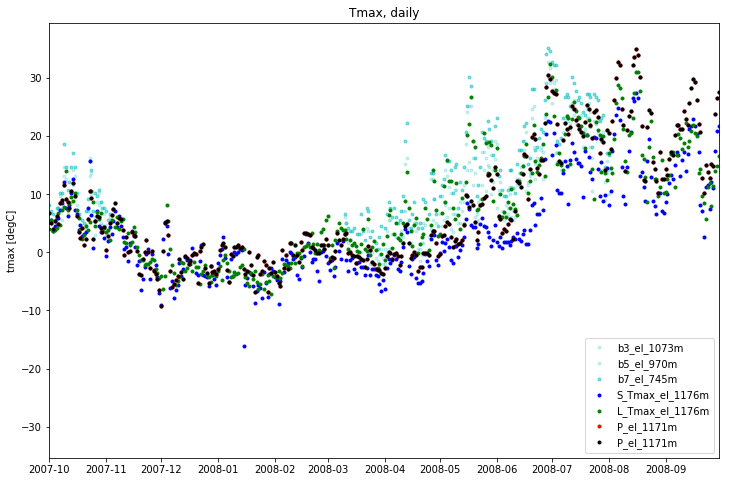

In [175]:

## Daily Tmax

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
#ax.plot(dfd_mx.iloc[:,0],'c.',linewidth=2.0,alpha=.2,label = 'b1_el_'+str(mat['elev'][0,0])+'m')
ax.plot(dfd_mx.iloc[:,2],'c.',linewidth=2.0,alpha=.2,label = 'b3_el_'+str(mat['elev'][0,2])+'m')
ax.plot(dfd_mx.iloc[:,4],'c.',linewidth=2.0,alpha=.2,label = 'b5_el_'+str(mat['elev'][0,4])+'m')
ax.plot(dfd_mx.iloc[:,6],'c.',linewidth=2.0,alpha=.5,label = 'b7_el_'+str(mat['elev'][0,6])+'m')
#ax.plot(dfd_mx.iloc[:,8],'c.',linewidth=2.0,alpha=.8,label = 'b9_el_'+str(mat['elev'][0,8])+'m')
#ax.plot(dfd_mx.iloc[:,10],'c.',linewidth=2.0,label = 'b11_Tmax_el_'+str(mat['elev'][0,10])+'m')
ax.plot(ltm['TMAX_dailywrf_salathe2014'].iloc[:,12],'b.',linewidth=2.0,label = 'S_Tmax_el_1176m')
ax.plot(ltm['TMAX_dailymet_livneh2013'].iloc[:,12],'g.',linewidth=2.0,label = 'L_Tmax_el_1176m')

ax.plot(PNdmx,'r.',linewidth=2.0,label = 'P_el_1171m')
a#x.plot(Ldict[0]['T2_hourlywrf_pnnl'].iloc[:,26].resample('D').max()-273.15,'k.',linewidth=2.0,label = 'P_el_1171m')
# =============================================================================
# ax.plot(Tmx_S_d.index,Tmx_S_d,'g.',linewidth=2.0,label = 'Salathe')
# ax.plot(PNNL_hT_v_d_mx.index, PNNL_hT_v_d_mx,'r.',alpha = .2,linewidth=2.0,label = 'PNNL')
# 
# =============================================================================
plt.xlim(['2007-10-01','2008-09-30'])
# plt.ylim([0,1])
# plt.xticks(np.arange(0, 1.5, .25))
#plt.xlabel('date')
plt.ylabel('tmax [degC]')
plt.title('Tmax, daily')
#plt.grid()

legend = ax.legend(loc = 'lower right')
plt.savefig('LE_Tmax_d.jpg', dpi = 300, bbox_inches='tight')

plt.show()

In [148]:
mat['elev']

array([[ 364,  364, 1073, 1073,  970,  970,  745,  745,  703,  703,  721,
         721, 1729, 1729, 1843,  593,  593,  797,  797, 1133, 1133, 1640,
        1640, 1167,  697, 1222, 1222, 1516, 1516, 1725]], dtype=uint16)

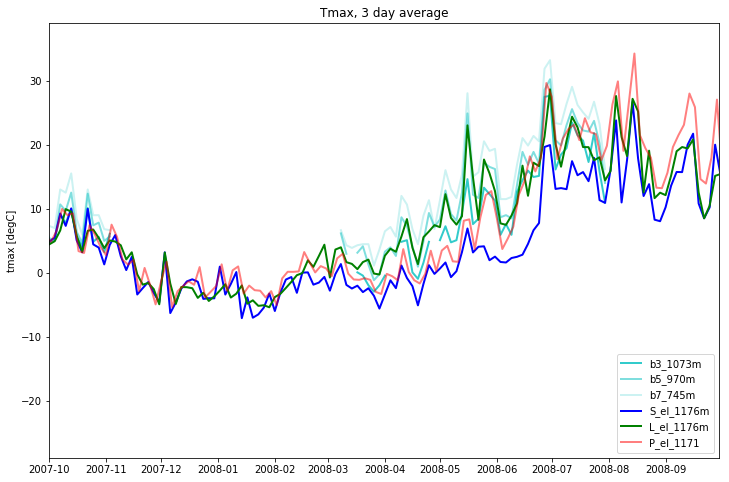

In [182]:
## 3 Day Tmax

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(dfd_mx.iloc[:,2].resample('3D').mean(),'c-',linewidth=2.0,alpha=.8,label = 'b3_'+str(mat['elev'][0,2])+'m')
ax.plot(dfd_mx.iloc[:,4].resample('3D').mean(),'c-',linewidth=2.0,alpha=.5,label = 'b5_'+str(mat['elev'][0,4])+'m')
ax.plot(dfd_mx.iloc[:,6].resample('3D').mean(),'c-',linewidth=2.0,alpha=.2,label = 'b7_'+str(mat['elev'][0,6])+'m')
#ax.plot(dfd_mx.iloc[:,10].resample('3D').mean(),'c-',linewidth=2.0,label = 'b11_Tmax')
ax.plot(ltm['TMAX_dailywrf_salathe2014'].iloc[:,12].resample('3D').mean(),'b-',linewidth=2.0,label = 'S_el_1176m')
ax.plot(ltm['TMAX_dailymet_livneh2013'].iloc[:,12].resample('3D').mean(),'g-',linewidth=2.0,label = 'L_el_1176m')
ax.plot(PNdmx.resample('3D').mean(),'r-',linewidth=2.0,alpha = .5,label = 'P_el_1171')
#check that chunk data is same as concatenated data set =>slight difference due to moving average starting on different day
#ax.plot(Ldict[1]['T2_hourlywrf_pnnl'].iloc[:,26].resample('3D').max()-273.15,'y-',linewidth=2.0,label = 'P_Tmax')
# =============================================================================
# ax.plot(Tmx_S_d.index,Tmx_S_d,'g.',linewidth=2.0,label = 'Salathe')
# ax.plot(PNNL_hT_v_d_mx.index, PNNL_hT_v_d_mx,'r.',alpha = .2,linewidth=2.0,label = 'PNNL')
# 
# =============================================================================
plt.xlim(['2007-10-01','2008-09-30'])
# plt.ylim([0,1])
# plt.xticks(np.arange(0, 1.5, .25))
#plt.xlabel('date')
plt.ylabel('tmax [degC]')
plt.title('Tmax, 3 day average')
#plt.grid()

legend = ax.legend(loc = 'lower right')
plt.savefig('LE_Tmax_3d.jpg', dpi = 300, bbox_inches='tight')

plt.show()

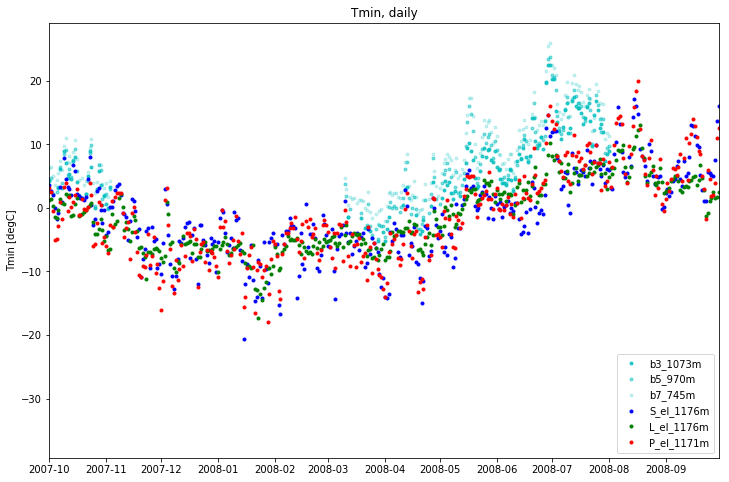

In [179]:

## Daily Tmin

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(dfd_min.iloc[:,2],'c.',linewidth=2.0,alpha=.8,label = 'b3_'+str(mat['elev'][0,2])+'m')
ax.plot(dfd_min.iloc[:,4],'c.',linewidth=2.0,alpha=.5,label = 'b5_'+str(mat['elev'][0,4])+'m')
ax.plot(dfd_min.iloc[:,6],'c.',linewidth=2.0,alpha=.2,label = 'b7_'+str(mat['elev'][0,6])+'m')
ax.plot(ltm['TMIN_dailywrf_salathe2014'].iloc[:,12],'b.',linewidth=2.0,label = 'S_el_1176m')
ax.plot(ltm['TMIN_dailymet_livneh2013'].iloc[:,12],'g.',linewidth=2.0,label = 'L_el_1176m')
ax.plot(PNdmn,'r.',linewidth=2.0,label = 'P_el_1171m')
#ax.plot(ltm['T2_hourlywrf_pnnl'].iloc[:,26]-273.15,'r.',linewidth=2.0,label = 'P_Tmin')
# =============================================================================
# ax.plot(Tmx_S_d.index,Tmx_S_d,'g.',linewidth=2.0,label = 'Salathe')
# ax.plot(PNNL_hT_v_d_mx.index, PNNL_hT_v_d_mx,'r.',alpha = .2,linewidth=2.0,label = 'PNNL')
# 
# =============================================================================
plt.xlim(['2007-10-01','2008-09-30'])
# plt.ylim([0,1])
# plt.xticks(np.arange(0, 1.5, .25))
#plt.xlabel('date')
plt.ylabel('Tmin [degC]')
plt.title('Tmin, daily')
#plt.grid()

legend = ax.legend(loc = 'lower right')
plt.savefig('LE_Tmin_d.jpg', dpi = 300, bbox_inches='tight')

plt.show()

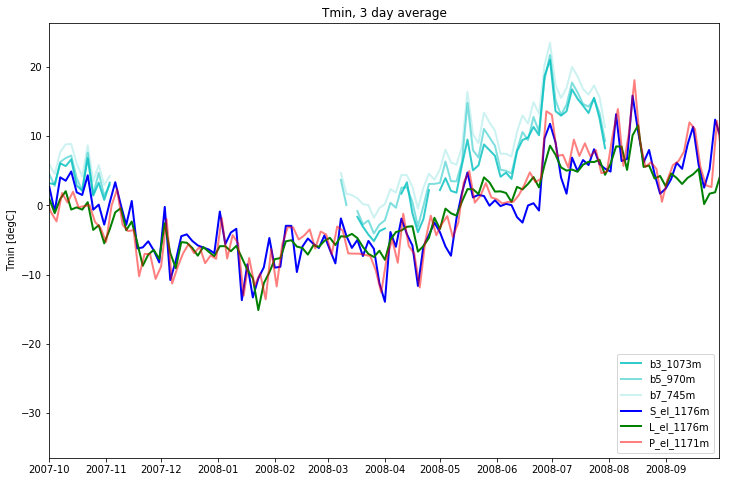

In [192]:
## 3 Day Tmin

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(dfd_min.iloc[:,2].resample('3D').mean(),'c-',linewidth=2.0,alpha=.8,label = 'b3_'+str(mat['elev'][0,2])+'m')
ax.plot(dfd_min.iloc[:,4].resample('3D').mean(),'c-',linewidth=2.0,alpha=.5,label = 'b5_'+str(mat['elev'][0,4])+'m')
ax.plot(dfd_min.iloc[:,6].resample('3D').mean(),'c-',linewidth=2.0,alpha=.2,label = 'b7_'+str(mat['elev'][0,6])+'m')

ax.plot(ltm['TMIN_dailywrf_salathe2014'].iloc[:,12].resample('3D').mean(),'b-',linewidth=2.0,label = 'S_el_1176m')
ax.plot(ltm['TMIN_dailymet_livneh2013'].iloc[:,12].resample('3D').mean(),'g-',linewidth=2.0,label = 'L_el_1176m')
ax.plot(PNdmn.resample('3D').mean(),'r-',linewidth=2.0,alpha = .5,label = 'P_el_1171m')
# =============================================================================
# ax.plot(Tmx_S_d.index,Tmx_S_d,'g.',linewidth=2.0,label = 'Salathe')
# ax.plot(PNNL_hT_v_d_mx.index, PNNL_hT_v_d_mx,'r.',alpha = .2,linewidth=2.0,label = 'PNNL')
# 
# =============================================================================
plt.xlim(['2007-10-01','2008-09-30'])
# plt.ylim([0,1])
# plt.xticks(np.arange(0, 1.5, .25))
#plt.xlabel('date')
plt.ylabel('Tmin [degC]')
plt.title('Tmin, 3 day average')
#plt.grid()

legend = ax.legend(loc = 'lower right')
plt.savefig('LE_Tmin_3d.jpg', dpi = 300, bbox_inches='tight')

plt.show()

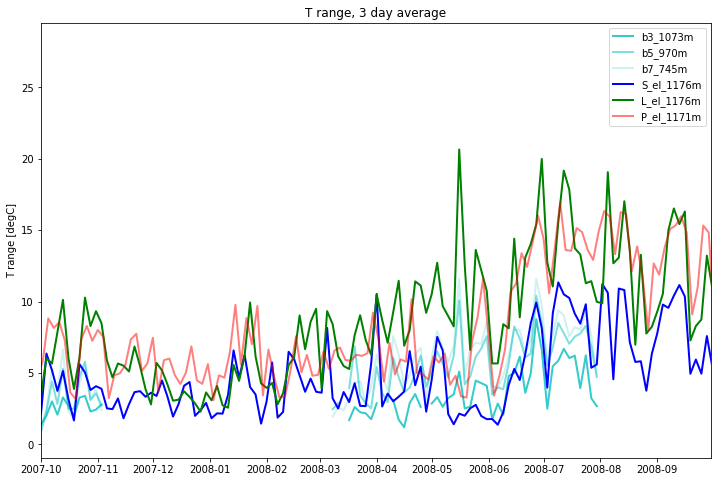

In [196]:
## 3 Day spread

o1s = dfd_mx.iloc[:,2].resample('3D').mean()-dfd_min.iloc[:,2].resample('3D').mean()
o4s = dfd_mx.iloc[:,4].resample('3D').mean()-dfd_min.iloc[:,4].resample('3D').mean()
o6s = dfd_mx.iloc[:,6].resample('3D').mean()-dfd_min.iloc[:,6].resample('3D').mean()
ls = ltm['TMAX_dailywrf_salathe2014'].iloc[:,12].resample('3D').mean()-ltm['TMIN_dailywrf_salathe2014'].iloc[:,12].resample('3D').mean()
Ss = ltm['TMAX_dailymet_livneh2013'].iloc[:,12].resample('3D').mean()-ltm['TMIN_dailymet_livneh2013'].iloc[:,12].resample('3D').mean()
Ps = PNdmx.resample('3D').mean()-PNdmn.resample('3D').mean()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(o1s,'c-',linewidth=2.0,alpha=.8,label = 'b3_'+str(mat['elev'][0,2])+'m')
ax.plot(o4s,'c-',linewidth=2.0,alpha=.5,label = 'b5_'+str(mat['elev'][0,4])+'m')
ax.plot(o6s,'c-',linewidth=2.0,alpha=.2,label = 'b7_'+str(mat['elev'][0,6])+'m')

ax.plot(ls,'b-',linewidth=2.0,label = 'S_el_1176m')
ax.plot(Ss,'g-',linewidth=2.0,label = 'L_el_1176m')
ax.plot(Ps,'r-',linewidth=2.0,alpha = .5,label = 'P_el_1171m')
# =============================================================================
# ax.plot(Tmx_S_d.index,Tmx_S_d,'g.',linewidth=2.0,label = 'Salathe')
# ax.plot(PNNL_hT_v_d_mx.index, PNNL_hT_v_d_mx,'r.',alpha = .2,linewidth=2.0,label = 'PNNL')
# 
# =============================================================================
plt.xlim(['2007-10-01','2008-09-30'])
# plt.ylim([0,1])
# plt.xticks(np.arange(0, 1.5, .25))
#plt.xlabel('date')
plt.ylabel('T range [degC]')
plt.title('T range, 3 day average')
#plt.grid()

legend = ax.legend(loc = 'upper right')
plt.savefig('LE_Range_3d.jpg', dpi = 300, bbox_inches='tight')

plt.show()

### High el

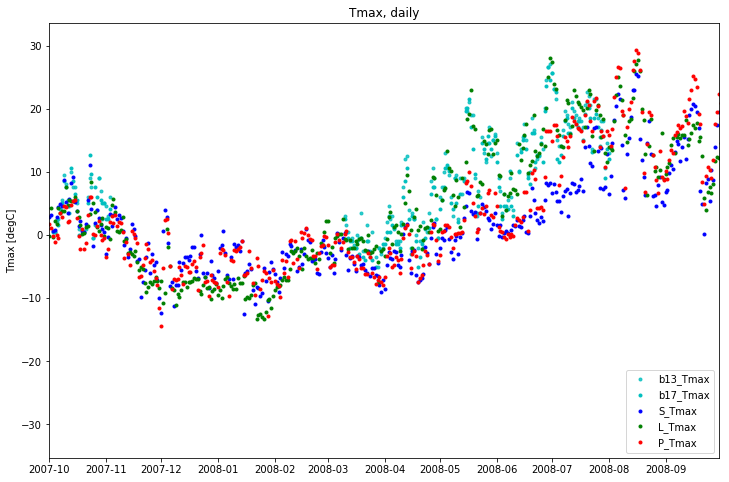

In [184]:
## High El, Daily Tmax

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(dfd_mx.iloc[:,12],'c.',linewidth=2.0,alpha=.8,label = 'b13_Tmax')
ax.plot(dfd_mx.iloc[:,14],'c.',linewidth=2.0,label = 'b17_Tmax')
ax.plot(ltm['TMAX_dailywrf_salathe2014'].iloc[:,29],'b.',linewidth=2.0,label = 'S_Tmax')
ax.plot(ltm['TMAX_dailymet_livneh2013'].iloc[:,29],'g.',linewidth=2.0,label = 'L_Tmax')
ax.plot(PNdmx_H,'r.',linewidth=2.0,label = 'P_Tmax')
# =============================================================================
# ax.plot(Tmx_S_d.index,Tmx_S_d,'g.',linewidth=2.0,label = 'Salathe')
# ax.plot(PNNL_hT_v_d_mx.index, PNNL_hT_v_d_mx,'r.',alpha = .2,linewidth=2.0,label = 'PNNL')
# 
# =============================================================================
plt.xlim(['2007-10-01','2008-09-30'])
# plt.ylim([0,1])
# plt.xticks(np.arange(0, 1.5, .25))
#plt.xlabel('date')
plt.ylabel('Tmax [degC]')
plt.title('Tmax, daily')
#plt.grid()

legend = ax.legend(loc = 'lower right')
plt.savefig('UE_Tmax_d.jpg', dpi = 300, bbox_inches='tight')

plt.show()

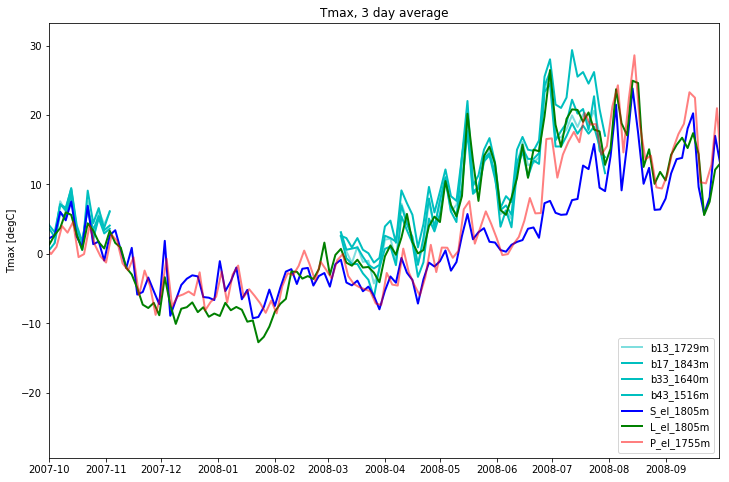

In [206]:
## 3 Day Tmax

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(dfd_mx.iloc[:,12].resample('3D').mean(),'c-',linewidth=2.0,alpha=.5,label = 'b13_'+str(mat['elev'][0,12])+'m')
ax.plot(dfd_mx.iloc[:,14].resample('3D').mean(),'c-',linewidth=2.0,label = 'b17_'+str(mat['elev'][0,14])+'m')
ax.plot(dfd_mx.iloc[:,21].resample('3D').mean(),'c-',linewidth=2.0,label = 'b33_'+str(mat['elev'][0,21])+'m')
ax.plot(dfd_mx.iloc[:,27].resample('3D').mean(),'c-',linewidth=2.0,label = 'b43_'+str(mat['elev'][0,27])+'m')
ax.plot(ltm['TMAX_dailywrf_salathe2014'].iloc[:,29].resample('3D').mean(),'b-',linewidth=2.0,label = 'S_el_1805m')
ax.plot(ltm['TMAX_dailymet_livneh2013'].iloc[:,29].resample('3D').mean(),'g-',linewidth=2.0,label = 'L_el_1805m')
ax.plot(PNdmx_H.resample('3D').mean(),'r-',linewidth=2.0,alpha=.5,label = 'P_el_1755m')
# =============================================================================
# ax.plot(Tmx_S_d.index,Tmx_S_d,'g.',linewidth=2.0,label = 'Salathe')
# ax.plot(PNNL_hT_v_d_mx.index, PNNL_hT_v_d_mx,'r.',alpha = .2,linewidth=2.0,label = 'PNNL')
# 
# =============================================================================
plt.xlim(['2007-10-01','2008-09-30'])
# plt.ylim([0,1])
# plt.xticks(np.arange(0, 1.5, .25))
#plt.xlabel('date')
plt.ylabel('Tmax [degC]')
plt.title('Tmax, 3 day average')
#plt.grid()

legend = ax.legend(loc = 'lower right')
plt.savefig('UE_Tmax_3d.jpg', dpi = 300, bbox_inches='tight')

plt.show()

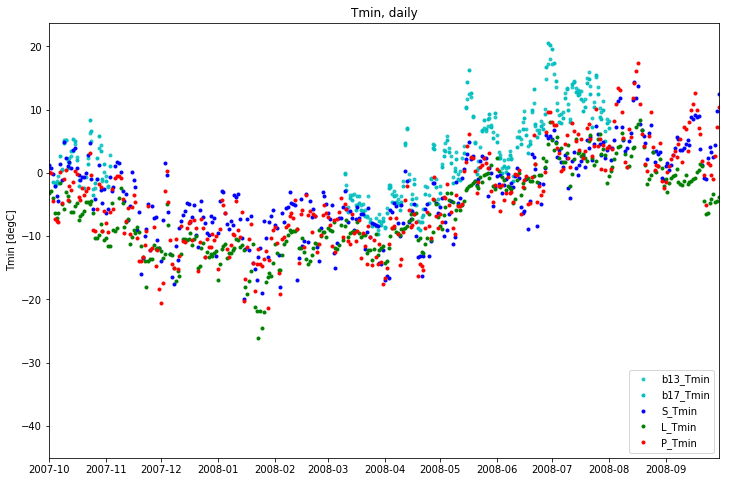

In [186]:

## Daily Tmin

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(dfd_min.iloc[:,12],'c.',linewidth=2.0,alpha=.8,label = 'b13_Tmin')
ax.plot(dfd_min.iloc[:,14],'c.',linewidth=2.0,label = 'b17_Tmin')
ax.plot(ltm['TMIN_dailywrf_salathe2014'].iloc[:,29],'b.',linewidth=2.0,label = 'S_Tmin')
ax.plot(ltm['TMIN_dailymet_livneh2013'].iloc[:,29],'g.',linewidth=2.0,label = 'L_Tmin')
ax.plot(PNdmn_H,'r.',linewidth=2.0,label = 'P_Tmin')
# =============================================================================
# ax.plot(Tmx_S_d.index,Tmx_S_d,'g.',linewidth=2.0,label = 'Salathe')
# ax.plot(PNNL_hT_v_d_mx.index, PNNL_hT_v_d_mx,'r.',alpha = .2,linewidth=2.0,label = 'PNNL')
# 
# =============================================================================
plt.xlim(['2007-10-01','2008-09-30'])
# plt.ylim([0,1])
# plt.xticks(np.arange(0, 1.5, .25))
#plt.xlabel('date')
plt.ylabel('Tmin [degC]')
plt.title('Tmin, daily')
#plt.grid()

legend = ax.legend(loc = 'lower right')
plt.savefig('UE_Tmin_d.jpg', dpi = 300, bbox_inches='tight')

plt.show()

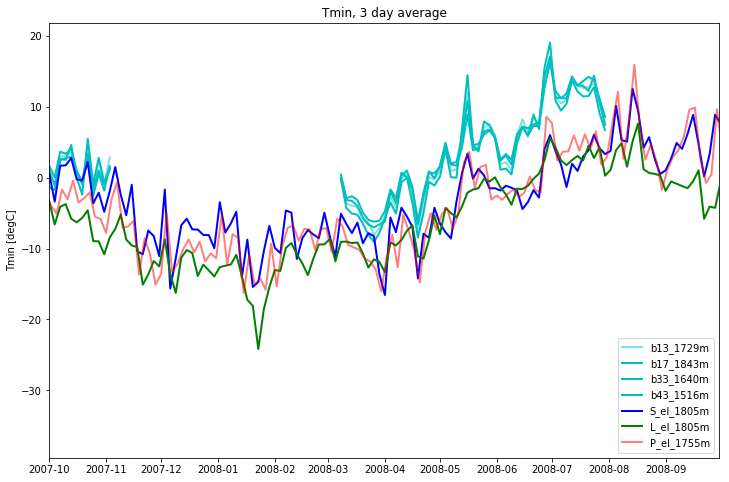

In [209]:
## 3 Day Tmin

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(dfd_min.iloc[:,12].resample('3D').mean(),'c-',linewidth=2.0,alpha=.5,label = 'b13_'+str(mat['elev'][0,12])+'m')
ax.plot(dfd_min.iloc[:,14].resample('3D').mean(),'c-',linewidth=2.0,label = 'b17_'+str(mat['elev'][0,14])+'m')
ax.plot(dfd_min.iloc[:,21].resample('3D').mean(),'c-',linewidth=2.0,label = 'b33_'+str(mat['elev'][0,21])+'m')
ax.plot(dfd_min.iloc[:,27].resample('3D').mean(),'c-',linewidth=2.0,label = 'b43_'+str(mat['elev'][0,27])+'m')
ax.plot(ltm['TMIN_dailywrf_salathe2014'].iloc[:,29].resample('3D').mean(),'b-',linewidth=2.0,label = 'S_el_1805m')
ax.plot(ltm['TMIN_dailymet_livneh2013'].iloc[:,29].resample('3D').mean(),'g-',linewidth=2.0,label = 'L_el_1805m')
ax.plot(PNdmn_H.resample('3D').mean(),'r-',linewidth=2.0,alpha = .5,label = 'P_el_1755m')
# =============================================================================
# ax.plot(Tmx_S_d.index,Tmx_S_d,'g.',linewidth=2.0,label = 'Salathe')
# ax.plot(PNNL_hT_v_d_mx.index, PNNL_hT_v_d_mx,'r.',alpha = .2,linewidth=2.0,label = 'PNNL')
# 
# =============================================================================
plt.xlim(['2007-10-01','2008-09-30'])
# plt.ylim([0,1])
# plt.xticks(np.arange(0, 1.5, .25))
#plt.xlabel('date')
plt.ylabel('Tmin [degC]')
plt.title('Tmin, 3 day average')
#plt.grid()

legend = ax.legend(loc = 'lower right')
plt.savefig('UE_Tmin_3d.jpg', dpi = 300, bbox_inches='tight')

plt.show()

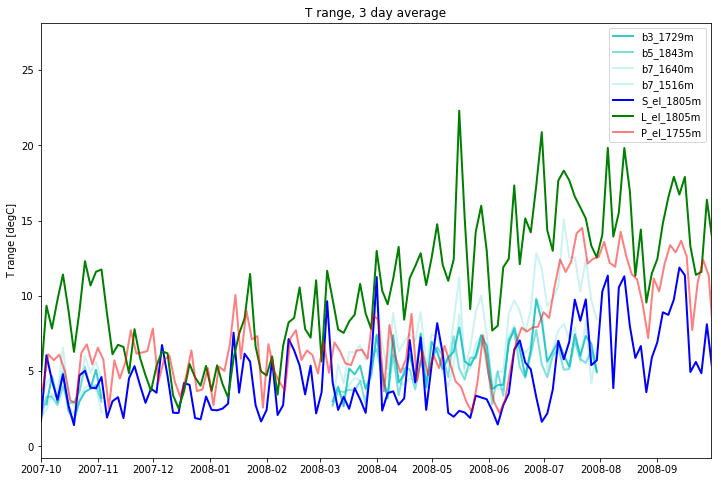

In [216]:
## 3 Day spread

o13s = dfd_mx.iloc[:,12].resample('3D').mean()-dfd_min.iloc[:,12].resample('3D').mean()
o17s = dfd_mx.iloc[:,14].resample('3D').mean()-dfd_min.iloc[:,14].resample('3D').mean()
o33s = dfd_mx.iloc[:,21].resample('3D').mean()-dfd_min.iloc[:,21].resample('3D').mean()
o43s = dfd_mx.iloc[:,27].resample('3D').mean()-dfd_min.iloc[:,27].resample('3D').mean()
ls = ltm['TMAX_dailywrf_salathe2014'].iloc[:,29].resample('3D').mean()-ltm['TMIN_dailywrf_salathe2014'].iloc[:,29].resample('3D').mean()
Ss = ltm['TMAX_dailymet_livneh2013'].iloc[:,29].resample('3D').mean()-ltm['TMIN_dailymet_livneh2013'].iloc[:,29].resample('3D').mean()
Ps = PNdmx_H.resample('3D').mean()-PNdmn_H.resample('3D').mean()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(o13s,'c-',linewidth=2.0,alpha=.8,label = 'b3_'+str(mat['elev'][0,12])+'m')
ax.plot(o17s,'c-',linewidth=2.0,alpha=.5,label = 'b5_'+str(mat['elev'][0,14])+'m')
ax.plot(o33s,'c-',linewidth=2.0,alpha=.2,label = 'b7_'+str(mat['elev'][0,21])+'m')
ax.plot(o43s,'c-',linewidth=2.0,alpha=.2,label = 'b7_'+str(mat['elev'][0,27])+'m')

ax.plot(ls,'b-',linewidth=2.0,label = 'S_el_1805m')
ax.plot(Ss,'g-',linewidth=2.0,label = 'L_el_1805m')
ax.plot(Ps,'r-',linewidth=2.0,alpha = .5,label = 'P_el_1755m')
# =============================================================================
# ax.plot(Tmx_S_d.index,Tmx_S_d,'g.',linewidth=2.0,label = 'Salathe')
# ax.plot(PNNL_hT_v_d_mx.index, PNNL_hT_v_d_mx,'r.',alpha = .2,linewidth=2.0,label = 'PNNL')
# 
# =============================================================================
plt.xlim(['2007-10-01','2008-09-30'])
# plt.ylim([0,1])
# plt.xticks(np.arange(0, 1.5, .25))
#plt.xlabel('date')
plt.ylabel('T range [degC]')
plt.title('T range, 3 day average')
#plt.grid()

legend = ax.legend(loc = 'upper right')
plt.savefig('HE_Range_3d.jpg', dpi = 300, bbox_inches='tight')

plt.show()

In [214]:
#TO DO
# ADD Elevaation of grid point, add more grid points
# Add elevation to tidbit
# Add more grid points, are all PNNL temps different from obs?
# Double check way pnnl netcdf fiels are appended. could it be that appended out of order?
9.28+1.94
#6.33-0.97
#8.57-1.12

11.219999999999999

In [215]:
pwd


'/home/jovyan/work/notebooks/GriddedMetDataDownload/projects/TemperatureSensorRegion'